In [1]:
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark = SparkSession.builder \
    .master("local") \
    .appName("AppName") \
    .getOrCreate()

In [89]:
# load the dataset
data = spark.read.csv("GROUP.csv.gz", header=True, sep=',',inferSchema="true")
data.dtypes

[('groupId', 'string'),
 ('matchId', 'string'),
 ('matchDuration', 'int'),
 ('winPlaceClass', 'int'),
 ('isFirstPerson', 'boolean'),
 ('matchtype', 'int'),
 ('maxPlace', 'int'),
 ('numGroups', 'int'),
 ('assist_SUM', 'int'),
 ('assist_AVG', 'int'),
 ('heals_SUM', 'int'),
 ('heals_AVG', 'int'),
 ('kills_SUM', 'int'),
 ('kills_AVG', 'int'),
 ('headshotKills_SUM', 'int'),
 ('headshotKills_AVG', 'int'),
 ('killStreaks_MAX', 'int'),
 ('roadKills_SUM', 'int'),
 ('roadKills_AVG', 'int'),
 ('longestKill_MAX', 'double'),
 ('vehicleDestroys_MAX', 'int'),
 ('weaponsAcquired_SUM', 'int'),
 ('weaponsAcquired_AVG', 'int'),
 ('damageDealt_SUM', 'double'),
 ('damageDealt_AVG', 'double'),
 ('distance_SUM', 'double'),
 ('distance_AVG', 'double'),
 ('rideDistance_SUM', 'double'),
 ('rideDistance_AVG', 'double'),
 ('swimDistance_SUM', 'double'),
 ('swimDistance_AVG', 'double'),
 ('walkDistance_SUM', 'double'),
 ('walkDistance_AVG', 'double'),
 ('DBNOs_SUM', 'int'),
 ('DBNOs_AVG', 'int'),
 ('revives_SUM', 

In [90]:
data.columns

['groupId',
 'matchId',
 'matchDuration',
 'winPlaceClass',
 'isFirstPerson',
 'matchtype',
 'maxPlace',
 'numGroups',
 'assist_SUM',
 'assist_AVG',
 'heals_SUM',
 'heals_AVG',
 'kills_SUM',
 'kills_AVG',
 'headshotKills_SUM',
 'headshotKills_AVG',
 'killStreaks_MAX',
 'roadKills_SUM',
 'roadKills_AVG',
 'longestKill_MAX',
 'vehicleDestroys_MAX',
 'weaponsAcquired_SUM',
 'weaponsAcquired_AVG',
 'damageDealt_SUM',
 'damageDealt_AVG',
 'distance_SUM',
 'distance_AVG',
 'rideDistance_SUM',
 'rideDistance_AVG',
 'swimDistance_SUM',
 'swimDistance_AVG',
 'walkDistance_SUM',
 'walkDistance_AVG',
 'DBNOs_SUM',
 'DBNOs_AVG',
 'revives_SUM',
 'revives_AVG',
 'teamKills_SUM',
 'teamKills_AVG',
 'killPlace_MAX',
 'rankPoints_MAX',
 'killPoints_MAX',
 'winPoints_MAX']

In [91]:
inputCols =  ['matchDuration', 
 'isFirstPerson',
 'matchtype',
 'maxPlace',
 'numGroups',
 'assist_SUM',
 'assist_AVG',
 'heals_SUM',
 'heals_AVG',
 'kills_SUM',
 'kills_AVG',
 'headshotKills_SUM',
 'headshotKills_AVG',
 'killStreaks_MAX',
 'roadKills_SUM',
 'roadKills_AVG',
 'longestKill_MAX',
 'vehicleDestroys_MAX',
 'weaponsAcquired_SUM',
 'weaponsAcquired_AVG',
 'damageDealt_SUM',
 'damageDealt_AVG',
 'distance_SUM',
 'distance_AVG',
 'rideDistance_SUM',
 'rideDistance_AVG',
 'swimDistance_SUM',
 'swimDistance_AVG',
 'walkDistance_SUM',
 'walkDistance_AVG',
 'DBNOs_SUM',
 'DBNOs_AVG',
 'revives_SUM',
 'revives_AVG',
 'teamKills_SUM',
 'teamKills_AVG',
 'killPlace_MAX',
 'rankPoints_MAX',
 'killPoints_MAX',
 'winPoints_MAX']

In [94]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=inputCols,
    outputCol="features")

output = assembler.transform(data)

In [95]:
seed = 42
withReplacement=False
output = output.sample(withReplacement, 0.04, seed) \
                .select("features", "winPlaceClass").withColumnRenamed('winPlaceClass', 'label')

(training,testing) = output.randomSplit([0.7,0.3])
print(F'training: {training.count()}')
print(F'testing: {testing.count()}')

training: 56324
testing: 24377


In [96]:
training.groupBy('label').count().toPandas()

,label,count
0,1,1378
1,6,1282
2,3,13106
3,5,13493
4,4,13932
5,2,13133


## GridSearch

In [18]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", impurity="gini", seed=42)

paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [3, 7, 12]) \
    .addGrid(dt.minInstancesPerNode, [5, 10, 20]) \
    #.addGrid(dt.minInfoGain, [0.5, 0.7]) \
    .build()

crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2) 

cvModel = crossval.fit(training)

In [22]:
cvModel.bestModel

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ee9fb718942c, depth=3, numNodes=13, numClasses=7, numFeatures=40

In [97]:
dt = DecisionTreeClassifier(maxDepth=10, labelCol="label",
                            featuresCol="features", impurity="gini",
                            minInstancesPerNode=10,
                            seed=42)
model = dt.fit(training)

In [98]:
predictions = model.transform(testing)
predictions.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(40,[0,1,2,3,4,5,...|    2|[0.0,472.0,5191.0...|[0.0,0.0746717291...|       2.0|
|(40,[0,1,2,3,4,5,...|    3|[0.0,2.0,129.0,63...|[0.0,0.0023696682...|       3.0|
|(40,[0,1,2,3,4,5,...|    2|[0.0,472.0,5191.0...|[0.0,0.0746717291...|       2.0|
|(40,[0,1,2,3,4,5,...|    3|[0.0,2.0,129.0,63...|[0.0,0.0023696682...|       3.0|
|(40,[0,1,2,3,4,5,...|    2|[0.0,472.0,5191.0...|[0.0,0.0746717291...|       2.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [99]:
features_importances = (
     pd.DataFrame(
       model.featureImportances.toArray(), 
       index=inputCols, 
       columns=['importance'])
)
features_importances.nlargest(20, columns='importance')

,importance
killPlace_MAX,0.554320
walkDistance_AVG,0.265558
distance_AVG,0.059478
numGroups,0.032005
matchDuration,0.020469
maxPlace,0.018729
kills_SUM,0.015386
distance_SUM,0.005965
walkDistance_SUM,0.004760
matchtype,0.003427


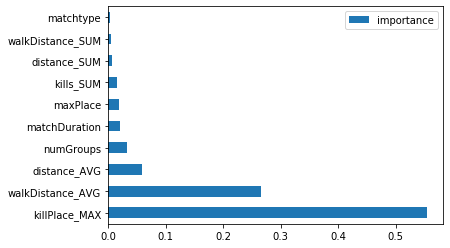

In [100]:
features_importances.nlargest(10, columns='importance').plot.barh()

In [103]:
print(model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_9763c67f6fe1, depth=10, numNodes=795, numClasses=7, numFeatures=40
  If (feature 36 <= 74.5)
   If (feature 29 <= 1076.4)
    If (feature 36 <= 60.5)
     If (feature 23 <= 399.2)
      If (feature 23 <= 102.0075)
       If (feature 9 <= 0.5)
        If (feature 3 <= 25.5)
         If (feature 20 <= 322.78)
          Predict: 1.0
         Else (feature 20 > 322.78)
          Predict: 6.0
        Else (feature 3 > 25.5)
         If (feature 4 <= 87.5)
          If (feature 2 <= 1.5)
           Predict: 5.0
          Else (feature 2 > 1.5)
           Predict: 3.0
         Else (feature 4 > 87.5)
          Predict: 3.0
       Else (feature 9 > 0.5)
        If (feature 29 <= 55.6725)
         Predict: 5.0
        Else (feature 29 > 55.6725)
         If (feature 4 <= 91.5)
          If (feature 0 <= 1415.5)
           If (feature 7 <= 0.5)
            Predict: 5.0
           Else (feature 7 > 0.5)
            Predict: 4.0
         

## Evaluation

In [101]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictionAndLabels = predictions.rdd.map(lambda x: (x.prediction, float(x.label)))
metrics = MulticlassMetrics(predictionAndLabels)

In [102]:
labels = [1,2,3,4,5,6]
# Summary stats
print("Recall = %s" % metrics.weightedRecall)
print("Precision = %s" % metrics.weightedPrecision)
print("F1 measure = %s" % metrics.weightedFMeasure())
print("Accuracy = %s" % metrics.accuracy)

# Individual label stats
labels = [1.0, 2.0 ,3.0, 4.0, 5.0, 6.0]
for label in labels:
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label)))
    
print('Confusion Matrix')
print(metrics.confusionMatrix().toArray())

Recall = 0.7654346310046355
Precision = 0.7641184852265598
F1 measure = 0.7633237500054878
Accuracy = 0.7654346310046355
Class 1.0 precision = 0.5801526717557252
Class 1.0 recall = 0.2895238095238095
Class 1.0 F1 Measure = 0.386277001270648
Class 2.0 precision = 0.7467061923583662
Class 2.0 recall = 0.8066180394947519
Class 2.0 F1 Measure = 0.7755067134182845
Class 3.0 precision = 0.6886492220650636
Class 3.0 recall = 0.6744588744588744
Class 3.0 F1 Measure = 0.6814801854605895
Class 4.0 precision = 0.764199935086011
Class 4.0 recall = 0.7854879065888241
Class 4.0 F1 Measure = 0.774697705025911
Class 5.0 precision = 0.8781859729302162
Class 5.0 recall = 0.8506725693853227
Class 5.0 F1 Measure = 0.8642103442311018
Class 6.0 precision = 0.6958955223880597
Class 6.0 recall = 0.6343537414965986
Class 6.0 F1 Measure = 0.6637010676156584
Confusion Matrix
[[1.520e+02 3.670e+02 6.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [9.400e+01 4.534e+03 9.660e+02 2.600e+01 1.000e+00 0.000e+00]
 [1.000e+01 1

In [57]:
evaluator = MulticlassClassificationEvaluator(labelCol="label",
                                              predictionCol="prediction")
evaluator.setMetricName('f1')
f1 = evaluator.evaluate(predictions)

#print("Test Error = %g " % (1.0 - accuracy))
print("F1 = %g " % f1)

F1 = 0.725057 


In [38]:
evaluator.setMetricName('accuracy')
accuracy = evaluator.evaluate(predictions)
print("accuracy = %g " % accuracy)

accuracy = 0.735367 


In [62]:
metrics = ['f1', 'accuracy',  'weightedPrecision',  'weightedRecall',  'weightedTruePositiveRate', 
          'weightedFalsePositiveRate',  'weightedFMeasure', 'truePositiveRateByLabel',
          'falsePositiveRateByLabel', 'precisionByLabel',  'recallByLabel',  'fMeasureByLabel',  'logLoss',  'hammingLoss']

byLabel = ['truePositiveRateByLabel','falsePositiveRateByLabel', 'precisionByLabel',  'recallByLabel',  'fMeasureByLabel']
labels = [1,2,3,4,5,6]

for metric in metrics:
    print(metric)
    evaluator.setMetricName(metric)
    
    if metric in byLabel:
        for c in  labels:
            evaluator.setMetricLabel(c)
            print(F'{c} = {evaluator.evaluate(predictions)}')
    else:
        print(evaluator.evaluate(predictions))
    print('#########################################################')

f1
0.7250574298966894
#########################################################
accuracy
0.7353666666666666
#########################################################
weightedPrecision
0.7200817833760604
#########################################################
weightedRecall
0.7353666666666667
#########################################################
weightedTruePositiveRate
0.7353666666666667
#########################################################
weightedFalsePositiveRate
0.08150905942758307
#########################################################
weightedFMeasure
0.7250574298966894
#########################################################
truePositiveRateByLabel
1 = 0.0
2 = 0.8111747851002865
3 = 0.6009876543209877
4 = 0.8039978168917997
5 = 0.8195253955037469
6 = 0.5003663003663004
#########################################################
falsePositiveRateByLabel
1 = 0.0
2 = 0.10043440486533449
3 = 0.09309328968903437
4 = 0.10987605310749415
5 = 0.03832148811090638
6 = 0.0044171

KeyboardInterrupt: 

In [ ]:
# (f1 | accuracy | weightedPrecision | weightedRecall | weightedTruePositiveRate | 
#  weightedFalsePositiveRate | weightedFMeasure | truePositiveRateByLabel | 
# falsePositiveRateByLabel | precisionByLabel | recallByLabel | fMeasureByLabel | 
# logLoss | hammingLoss

## Sklearn metrics

In [108]:
from sklearn.metrics import classification_report, confusion_matrix

In [107]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [109]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.58      0.29      0.39       525
           2       0.75      0.81      0.78      5621
           3       0.69      0.67      0.68      5775
           4       0.76      0.79      0.77      5995
           5       0.88      0.85      0.86      5873
           6       0.70      0.63      0.66       588

    accuracy                           0.77     24377
   macro avg       0.73      0.67      0.69     24377
weighted avg       0.76      0.77      0.76     24377



In [110]:
print(confusion_matrix(y_true, y_pred))

[[ 152  367    6    0    0    0]
 [  94 4534  966   26    1    0]
 [  10 1138 3895  727    5    0]
 [   0   33  775 4709  478    0]
 [   3    0   11  700 4996  163]
 [   3    0    3    0  209  373]]


In [111]:
spark.stop()